<a href="https://colab.research.google.com/github/Olga-1911/Development_of_a_convolutional_neural_network/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B8_%D0%9B%D0%B0%D0%B1_%D1%80%D0%B0%D0%B1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Лабораторная работа №3

**Разработка сверточной нейронной сети**

Для удобства импортируем все необходимые библиотеки и команды.

In [42]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import urllib.request
from PIL import Image
import io

np.random.seed(42)
tf.random.set_seed(42)

1. Выбрана библиотека TensorFlow с модулем Keras из-за простоты использования и встроенной поддержки в Google Colab.

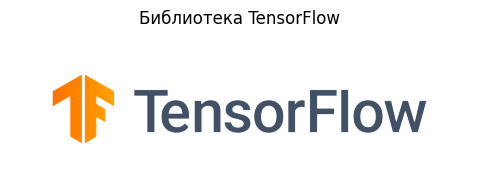

In [43]:
url = "https://www.tensorflow.org/images/tf_logo_horizontal.png"
urllib.request.urlretrieve(url, "tf_logo.png")
img = Image.open("tf_logo.png")

plt.figure(figsize=(6, 2))
plt.imshow(img)
plt.axis('off')
plt.title('Библиотека TensorFlow')
plt.savefig('tensorflow_logo.png')
plt.show()

2. TensorFlow версии 2.18.0 предустановлен в Google Colab, установка не потребовалась. Для проверки версии выполним следующий код:

In [44]:
import tensorflow as tf
print(tf.__version__)

2.18.0


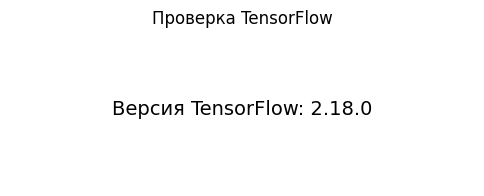

In [45]:
plt.figure(figsize=(6, 2))
plt.text(0.5, 0.5, f"Версия TensorFlow: {tf.__version__}",
         fontsize=14, ha='center', va='center')
plt.axis('off')
plt.title('Проверка TensorFlow')
plt.savefig('tf_version.png')
plt.show()

3. Проверка корректности установки (MNIST)

Создадим модель логистической регрессии для классификации рукописных цифр MNIST.

In [46]:
# Загрузка данных MNIST
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()

# Нормализация данных: приведение значений пикселей к диапазону [0, 1]
x_train_mnist = x_train_mnist.astype('float32') / 255.0
x_test_mnist = x_test_mnist.astype('float32') / 255.0

# Преобразование изображений в плоские векторы (28x28 → 784)
x_train_mnist = x_train_mnist.reshape(-1, 28*28)
x_test_mnist = x_test_mnist.reshape(-1, 28*28)

# Создание модели: один полносвязный слой с softmax
model_mnist = models.Sequential([
    layers.Dense(10, activation='softmax', input_shape=(784,))
])

# Компиляция модели: оптимизатор SGD, функция потерь — кросс-энтропия
model_mnist.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Обучение модели: 5 эпох, размер батча 32, 20% данных для валидации
history_mnist = model_mnist.fit(x_train_mnist, y_train_mnist, epochs=5, batch_size=32,
                               validation_split=0.2, verbose=1)

# Оценка модели на тестовых данных
test_loss_mnist, test_accuracy_mnist = model_mnist.evaluate(x_test_mnist, y_test_mnist)
print(f"Точность на тестовых данных MNIST: {test_accuracy_mnist:.4f}")

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6961 - loss: 1.1990 - val_accuracy: 0.8783 - val_loss: 0.5065
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8725 - loss: 0.5089 - val_accuracy: 0.8925 - val_loss: 0.4169
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8873 - loss: 0.4334 - val_accuracy: 0.8989 - val_loss: 0.3812
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8926 - loss: 0.3989 - val_accuracy: 0.9038 - val_loss: 0.3609
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8966 - loss: 0.3780 - val_accuracy: 0.9068 - val_loss: 0.3475
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8910 - loss: 0.3980
Точность на тестовых данных MNIST: 0.9062


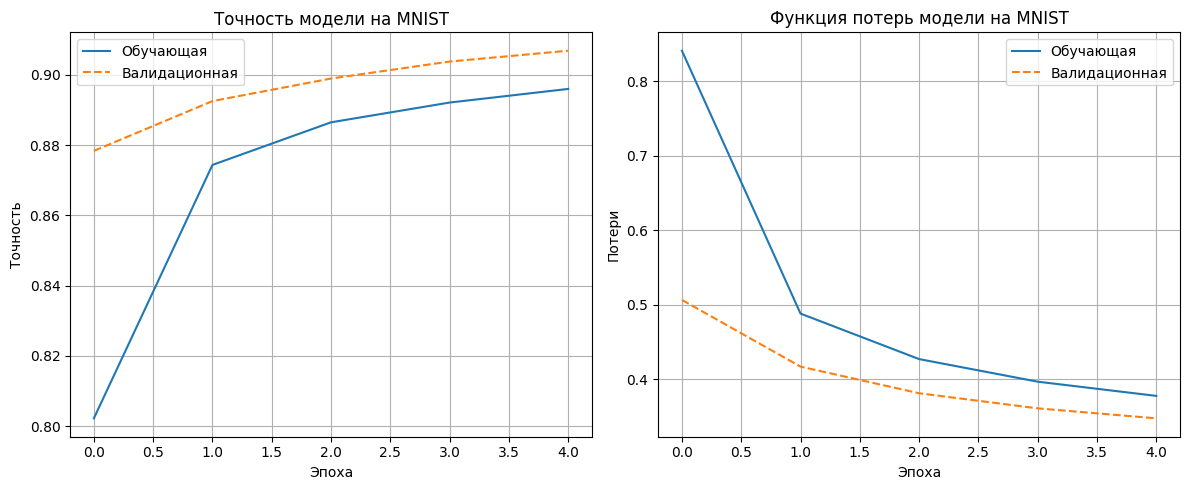

In [47]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_mnist.history['accuracy'], label='Обучающая')
plt.plot(history_mnist.history['val_accuracy'], '--', label='Валидационная')
plt.title('Точность модели на MNIST')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_mnist.history['loss'], label='Обучающая')
plt.plot(history_mnist.history['val_loss'], '--', label='Валидационная')
plt.title('Функция потерь модели на MNIST')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('mnist_training_metrics.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


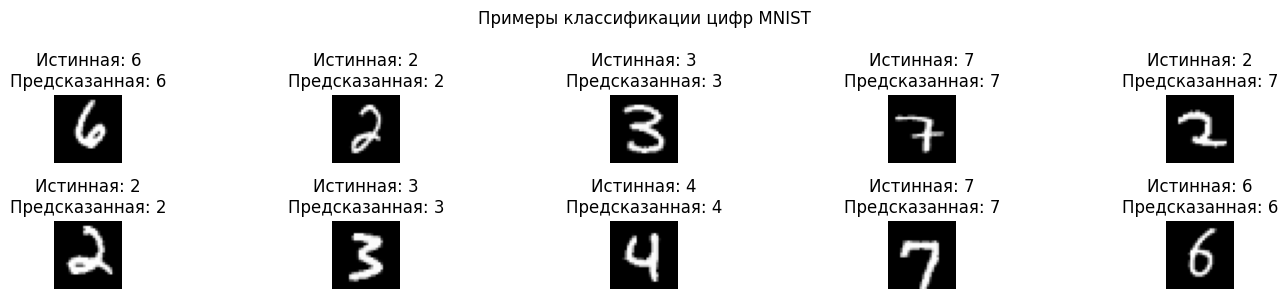

In [48]:
indices = np.random.choice(len(x_test_mnist), 10, replace=False)

predictions = model_mnist.predict(x_test_mnist[indices])

plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_mnist[idx].reshape(28, 28), cmap='gray')
    true_label = y_test_mnist[idx]
    pred_label = np.argmax(predictions[i])
    plt.title(f'Истинная: {true_label}\nПредсказанная: {pred_label}')
    plt.axis('off')

plt.suptitle('Примеры классификации цифр MNIST')
plt.tight_layout()
plt.savefig('mnist_classification_examples.png')
plt.show()

4. Для выполнения практических работ я выбрала практическую задачу компьютерного зрения - задачу классификации изображений из набора данных CIFAR-10. Этот набор данных доступен через TensorFlow.

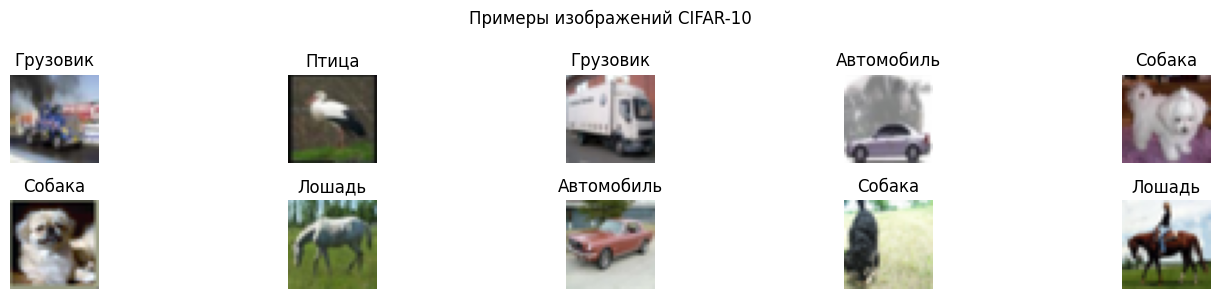

In [49]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

class_names = ['Самолёт', 'Автомобиль', 'Птица', 'Кот', 'Олень',
               'Собака', 'Лягушка', 'Лошадь', 'Корабль', 'Грузовик']

indices = np.random.choice(len(x_train), 10, replace=False)
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[idx])
    plt.title(class_names[y_train[idx][0]])
    plt.axis('off')
plt.suptitle('Примеры изображений CIFAR-10')
plt.tight_layout()
plt.savefig('cifar10_samples.png')
plt.show()

5. Для подготовки тренировочных и тестовых данных в формате, который обрабатывается выбранной библиотекой, произведем нормализацию данных, one-hot encoding и аугментацию.

In [50]:
# Нормализация данных: приведение пикселей к диапазону [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Преобразование меток в one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Настройка аугментации: повороты, сдвиги, отражения, масштабирование
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

# Применение аугментации к обучающим данным
datagen.fit(x_train)

# Вывод размеров выборок
print(f"Размер обучающей выборки: {x_train.shape}")
print(f"Размер тестовой выборки: {x_test.shape}")

Размер обучающей выборки: (50000, 32, 32, 3)
Размер тестовой выборки: (10000, 32, 32, 3)


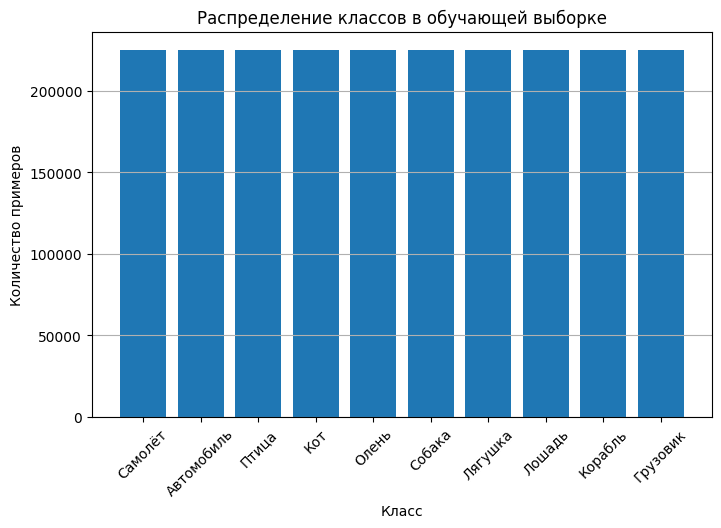

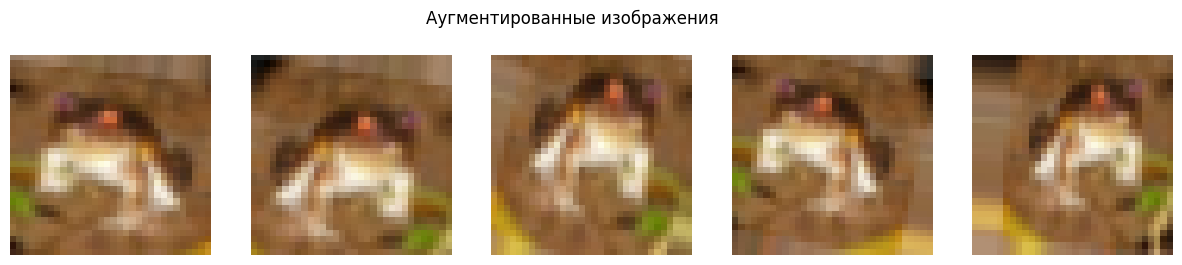

In [52]:
# Подсчёт числа примеров по классам
class_counts = np.sum(np.argmax(y_train, axis=1), axis=0)

# Построение гистограммы распределения классов
plt.figure(figsize=(8, 5))
plt.bar(class_names, class_counts)
plt.title('Распределение классов в обучающей выборке')
plt.xlabel('Класс')
plt.ylabel('Количество примеров')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.savefig('class_distribution.png')
plt.show()

# Генерация аугментированных изображений для примера
sample_image = x_train[0:1]
augmented_images = [next(datagen.flow(sample_image, batch_size=1))[0] for _ in range(5)]

# Визуализация аугментированных изображений
plt.figure(figsize=(15, 3))
for i, img in enumerate(augmented_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Аугментированные изображения')
plt.savefig('augmented_images.png')
plt.show()

6. Разработка архитектур

Модель 1: FCNN с 2 слоями

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,161,098 (12.06 MB)

 Trainable params: 3,159,050 (12.05 MB)

 Non-trainable params: 2,048 (8.00 KB)

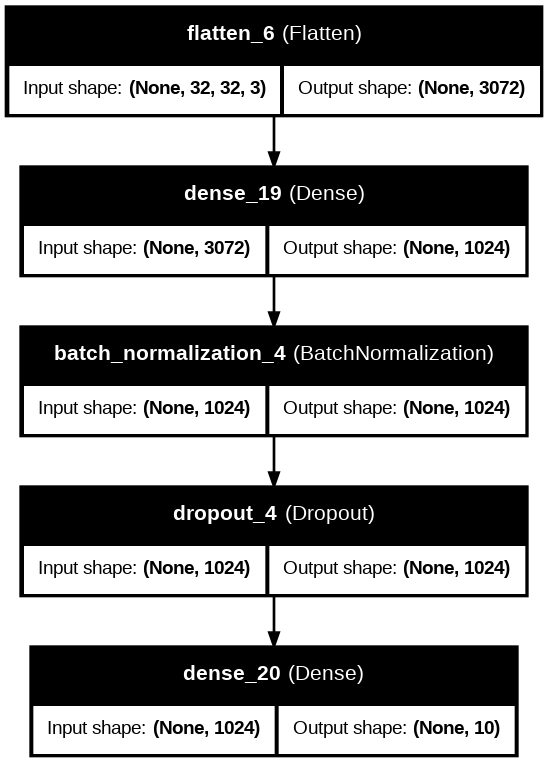

In [56]:
# Определение модели FCNN с 2 слоями
def build_fcnn_2_layers():
    model = models.Sequential([
        layers.Flatten(input_shape=(32, 32, 3)),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Создание и компиляция модели
model_fcnn_2 = build_fcnn_2_layers()
model_fcnn_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_fcnn_2.summary()

# Визуализация архитектуры модели
plot_model(model_fcnn_2, to_file='fcnn_2_layers.png', show_shapes=True,
           show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

Модель 2: FCNN с 3 слоями

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,642,890 (6.27 MB)

 Trainable params: 1,641,610 (6.26 MB)

 Non-trainable params: 1,280 (5.00 KB)

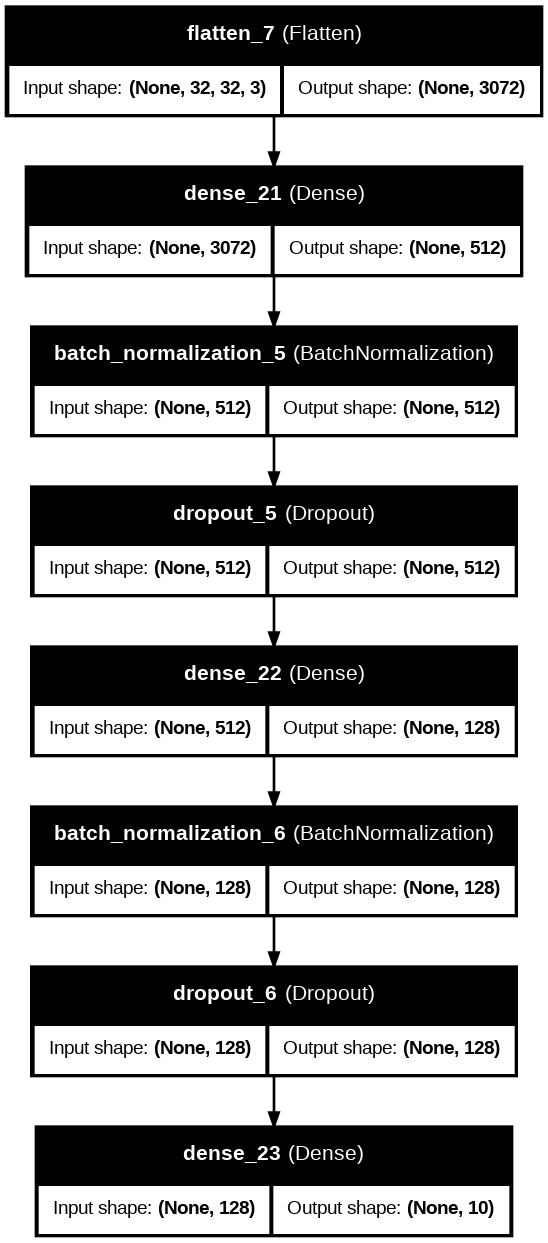

In [57]:
# Определение модели FCNN с 3 слоями
def build_fcnn_3_layers():
    model = models.Sequential([
        layers.Flatten(input_shape=(32, 32, 3)),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Создание и компиляция модели
model_fcnn_3 = build_fcnn_3_layers()
model_fcnn_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_fcnn_3.summary()

# Визуализация архитектуры модели
plot_model(model_fcnn_3, to_file='fcnn_3_layers.png', show_shapes=True,
           show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

Модель 3: CNN

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,463,690 (17.03 MB)

 Trainable params: 4,461,898 (17.02 MB)

 Non-trainable params: 1,792 (7.00 KB)

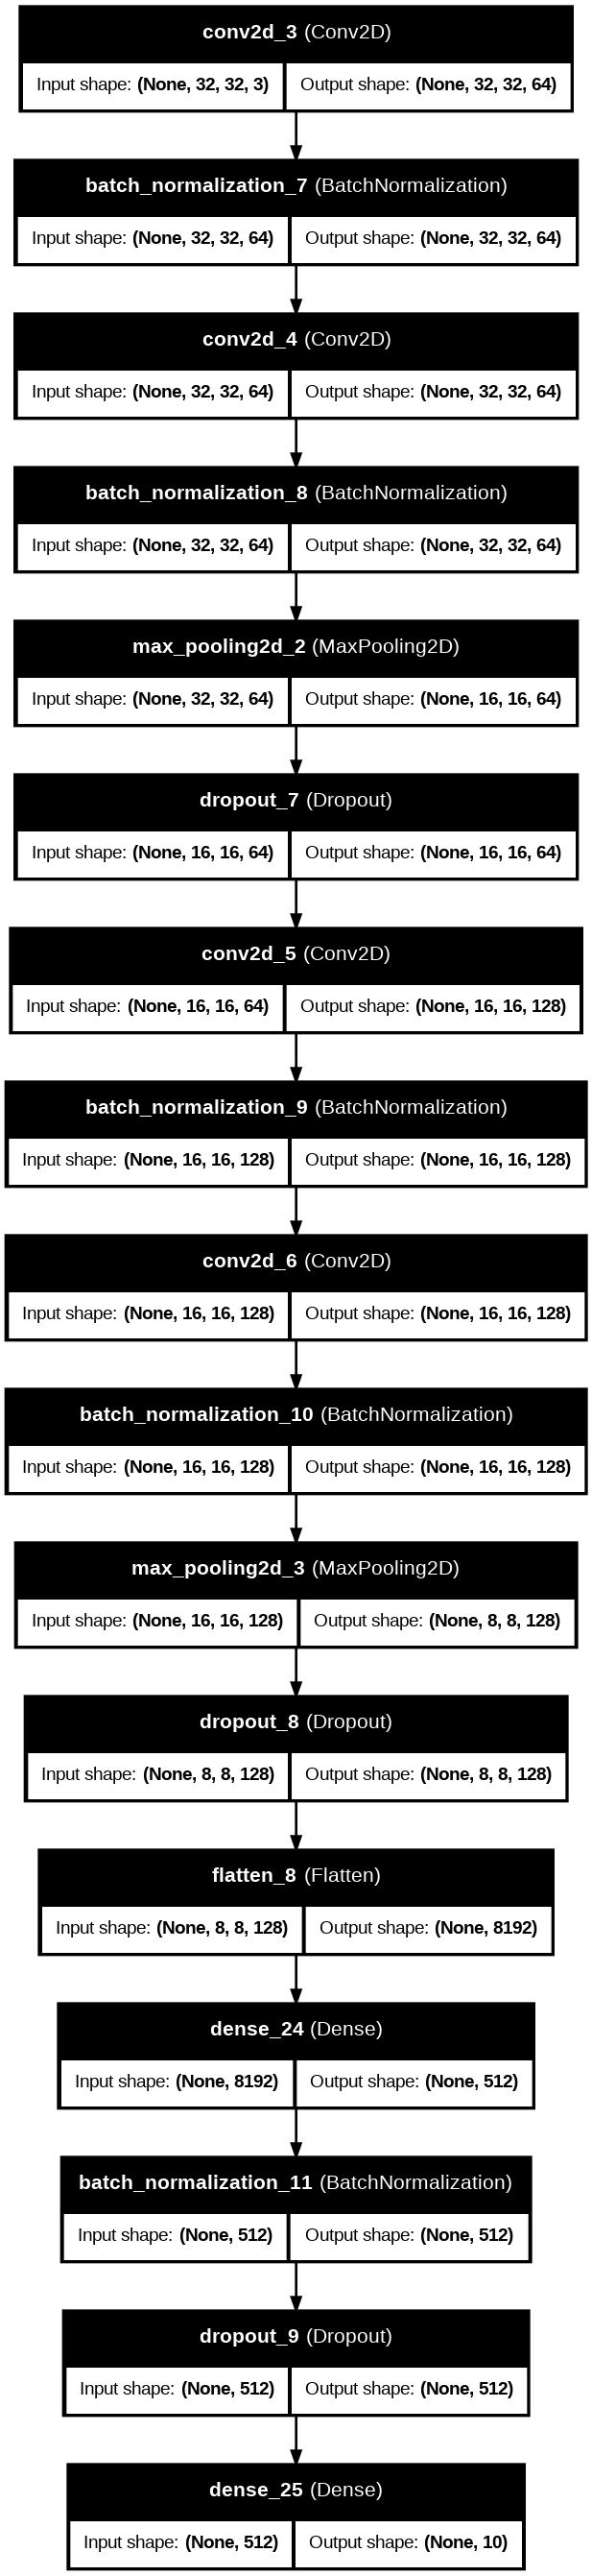

In [58]:
# Определение модели CNN
def build_cnn():
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Создание и компиляция модели
model_cnn = build_cnn()
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

# Визуализация архитектуры модели
plot_model(model_cnn, to_file='cnn.png', show_shapes=True,
           show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

7. Произведем обучение моделей

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 99ms/step - accuracy: 0.2782 - loss: 2.1350 - val_accuracy: 0.3385 - val_loss: 1.8663
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 101ms/step - accuracy: 0.3281 - loss: 1.9038 - val_accuracy: 0.3608 - val_loss: 1.8037
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/step - accuracy: 0.3455 - loss: 1.8490 - val_accuracy: 0.4007 - val_loss: 1.7040
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 67s 86ms/step - accuracy: 0.3627 - loss: 1.8115 - val_accuracy: 0.3994 - val_loss: 1.7045
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 85ms/step - accuracy: 0.3720 - loss: 1.7781 - val_accuracy: 0.3916 - val_loss: 1.7052
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 67s 85ms/step - accuracy: 0.3731 - loss: 1.7689 - val_accuracy: 0.3867 - val_loss: 1.6991
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 66s 85ms/step - accuracy: 0.3762 - loss: 1.7606 - val_accuracy: 0.4077 - val_loss: 1.6588
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 67s 85ms/step - accuracy: 0.3774 - loss: 1.7491 - val_accura

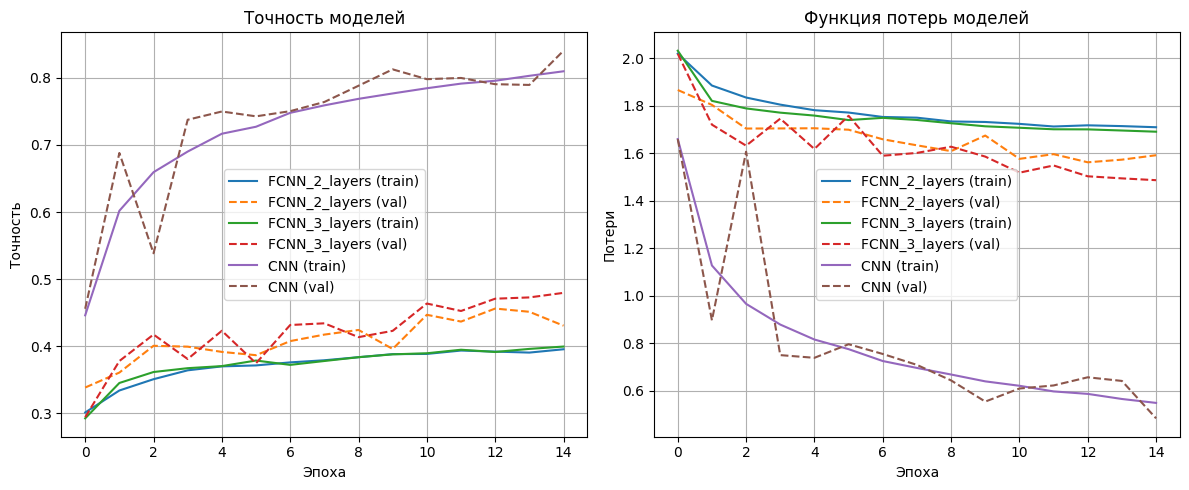

In [59]:
# Список моделей для обучения
models_list = [
    ('FCNN_2_layers', model_fcnn_2),
    ('FCNN_3_layers', model_fcnn_3),
    ('CNN', model_cnn)
]

# Сохранение результатов обучения
results = []
histories = {}
for name, model in models_list:
    # Измерение времени обучения
    start_time = time.time()
    if 'CNN' in name:
        # Обучение CNN с аугментацией
        history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                            epochs=15, validation_data=(x_test, y_test), verbose=1)
    else:
        # Обучение FCNN без аугментации
        history = model.fit(x_train, y_train, epochs=15, batch_size=64,
                            validation_data=(x_test, y_test), verbose=1)
    end_time = time.time()

    # Оценка модели на тестовых данных
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

    # Сохранение результатов
    results.append({
        'Model': name,
        'Training Time (s)': end_time - start_time,
        'Test Accuracy': test_accuracy
    })
    histories[name] = history

# Вывод результатов
for result in results:
    print(f"Модель: {result['Model']}, Время обучения: {result['Training Time (s)']:.2f} сек, Точность: {result['Test Accuracy']:.4f}")

# Визуализация точности и потерь
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name in histories:
    plt.plot(histories[name].history['accuracy'], label=f'{name} (train)')
    plt.plot(histories[name].history['val_accuracy'], '--', label=f'{name} (val)')
plt.title('Точность моделей')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for name in histories:
    plt.plot(histories[name].history['loss'], label=f'{name} (train)')
    plt.plot(histories[name].history['val_loss'], '--', label=f'{name} (val)')
plt.title('Функция потерь моделей')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

8. Произведем тестирование моделей

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 142ms/step


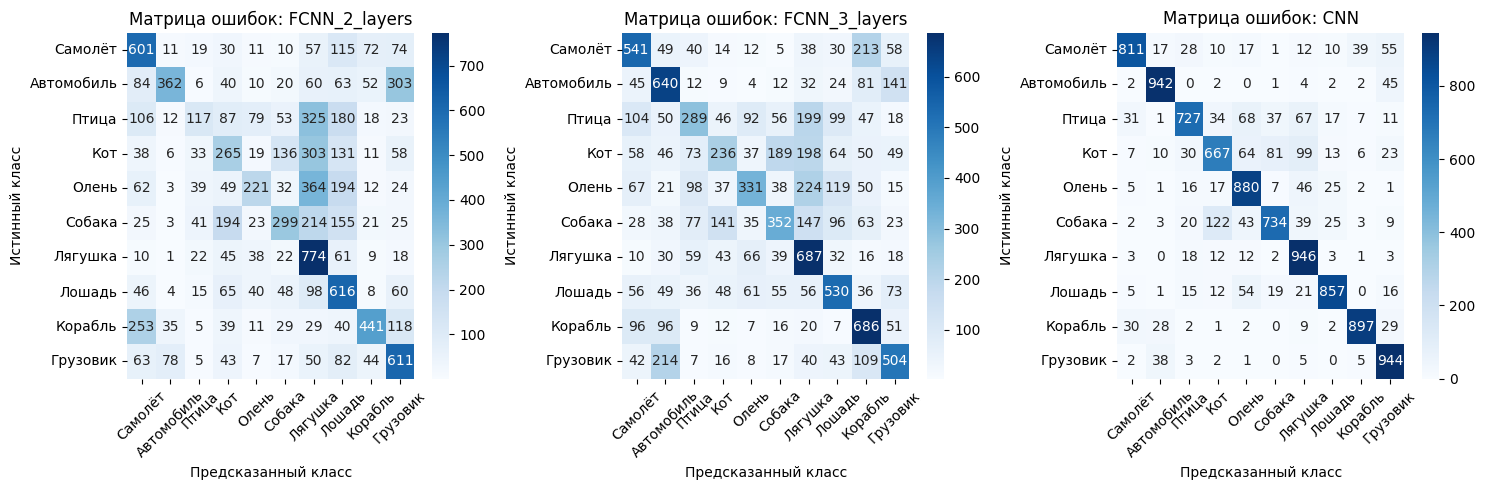

In [60]:
# Создание фигуры для матриц ошибок
plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(models_list, 1):
    # Получение предсказаний модели
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Вычисление матрицы ошибок
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Визуализация матрицы ошибок
    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Матрица ошибок: {name}')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

Рассмотрим пример применения

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


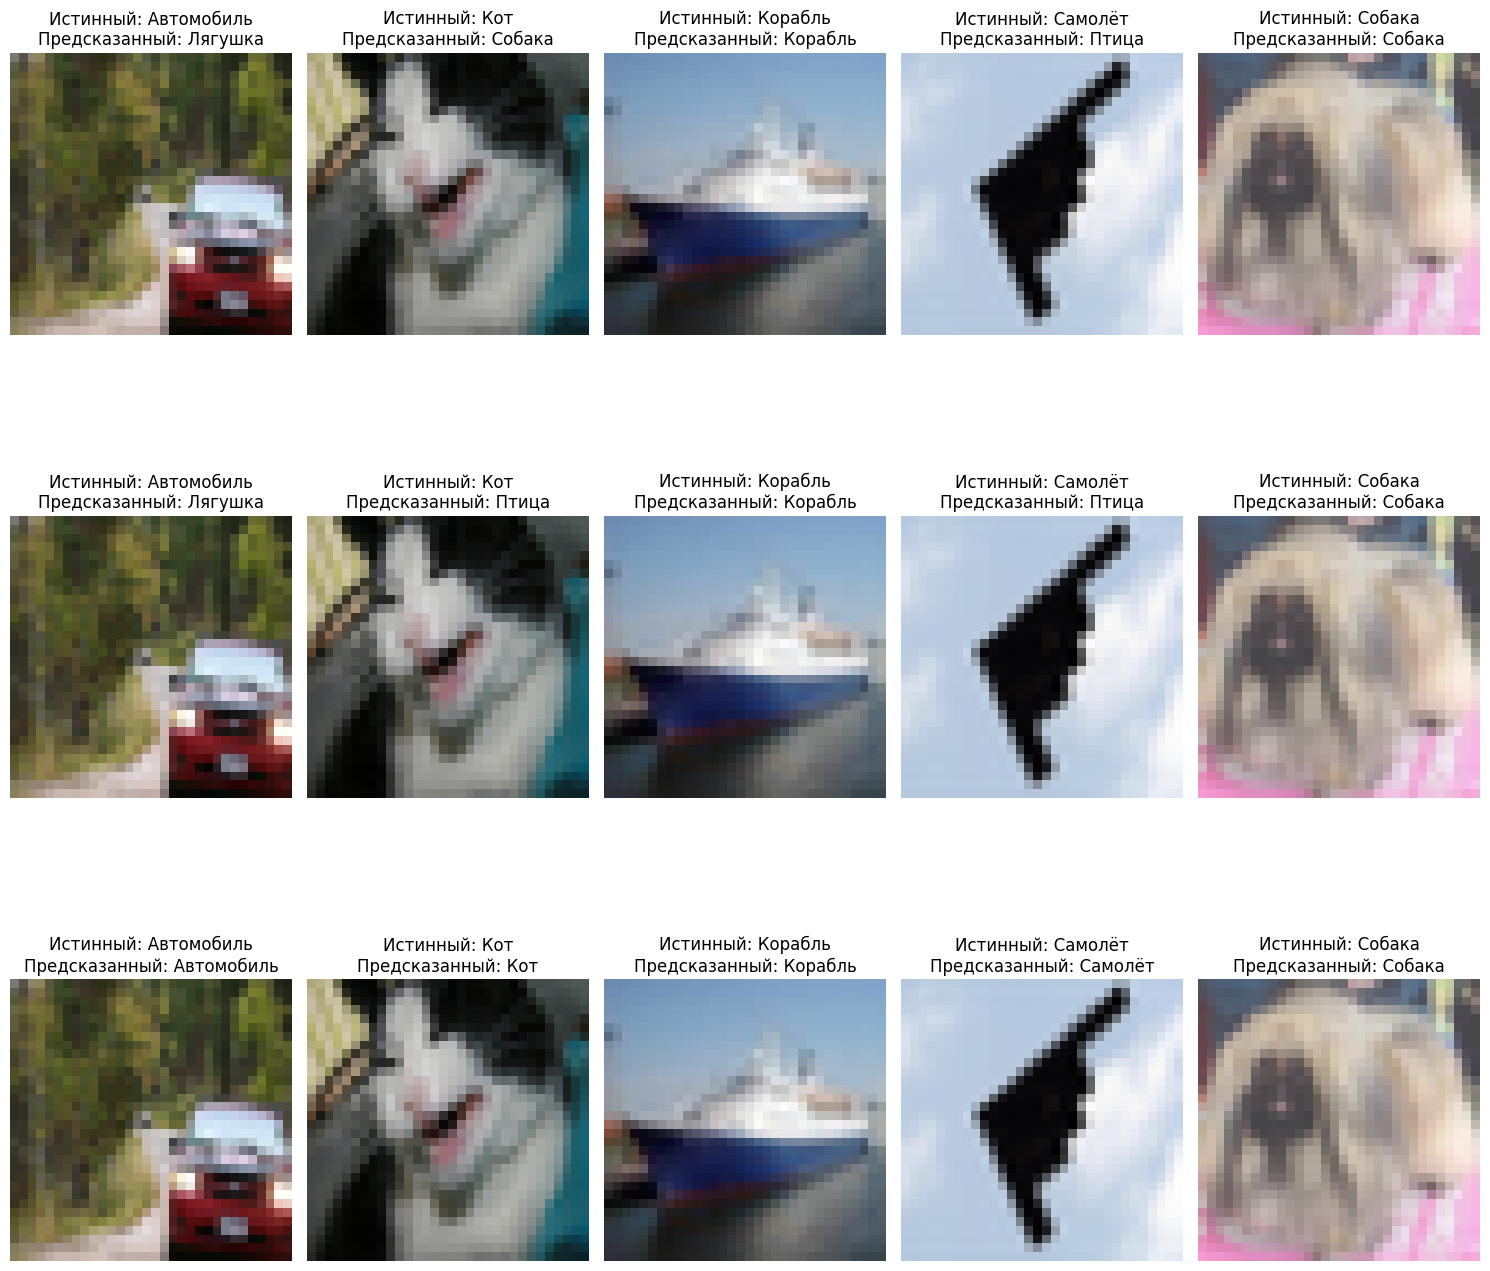

In [67]:
indices = np.random.choice(len(x_test), 5, replace=False)

plt.figure(figsize=(15, 5 * len(models_list)))
for m_idx, (model_name, model) in enumerate(models_list):
    predictions = model.predict(x_test[indices])

    for i, idx in enumerate(indices):
        plt.subplot(len(models_list), 5, m_idx * 5 + i + 1)
        plt.imshow(x_test[idx])
        true_label = class_names[np.argmax(y_test[idx])]
        pred_label = class_names[np.argmax(predictions[i])]
        plt.title(f'Истинный: {true_label}\nПредсказанный: {pred_label}')
        plt.axis('off')
        if i == 0:
            plt.ylabel(model_name, fontsize=12)

plt.tight_layout()
plt.savefig('classification_examples.png')
plt.show()

Сравненим FCNN и CNN, чтобы сделать выводы

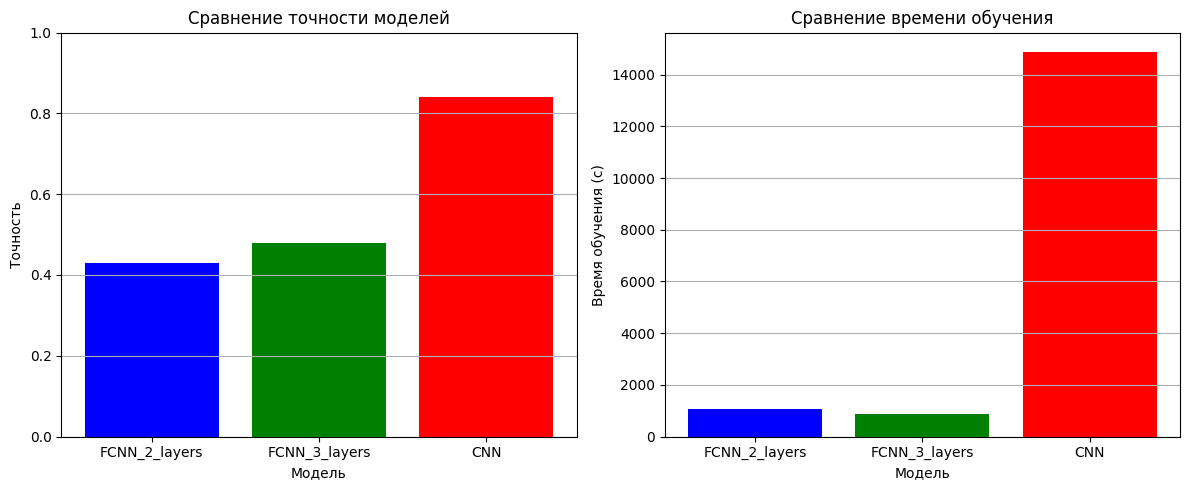

In [63]:
# Извлечение результатов для сравнения
model_names = [r['Model'] for r in results]
accuracies = [r['Test Accuracy'] for r in results]
training_times = [r['Training Time (s)'] for r in results]

# Создание фигуры для сравнения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.title('Сравнение точности моделей')
plt.xlabel('Модель')
plt.ylabel('Точность')
plt.ylim(0, 1)
plt.grid(True, axis='y')

plt.subplot(1, 2, 2)
plt.bar(model_names, training_times, color=['blue', 'green', 'red'])
plt.title('Сравнение времени обучения')
plt.xlabel('Модель')
plt.ylabel('Время обучения (с)')
plt.grid(True, axis='y')

plt.tight_layout()
plt.savefig('comparison.png')
plt.show()